In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
%config InlineBackend.figure_format='retina'

THE IDEAS:

During the demo, it occured to me that the **segmentation** step might be the most critical one. The user might already have a clear idea of some of the segmentation they want but with a dataset with a lot of dimensions **the number of combinations increase drastically** and it become easier to miss interesting segmentation for a **specific goal/conversion**. On the other hand, it's definetely a step that the user want to control. So I thought about a way to assist the user by exposing them to the **most discriminative dimension/feature for a specific goal**.

So the approach is the following:

    1) We assume we already have some historical data for this goal. This goal could be a simple signup or upsell conversion for example.
    2) We train a simple predictive model on this historical data.
    3) We look at the most predictive features of the model.
    4) We cook suggestions of segmentation using those most important features.

Obviously I don't have access to Simon Data Data Warehouse, so I'm going to test the idea on a dataset I already have on my laptop. To make thinks more interesting I did the test with a real dataset of the traffic for an anonymous web app. This is a dataset of **65M visits (session)** and **9.5M unique visitors**

    du -sh *
    mlaprise@Martins-MacBook-Pro $ du -sh *
    1.1G	traffic_aa
    1.1G	traffic_ab
    1.1G	traffic_ac
    1.1G	traffic_ad
    1.1G	traffic_ae
    1.1G	traffic_af
    1.1G	traffic_ag
    1.2G	traffic_ah
    1.2G	traffic_ai
    1.1G	traffic_aj
    1.1G	traffic_ak
    1.1G	traffic_al
    1.1G	traffic_am
    1.1G	traffic_an
    1.1G	traffic_ao
    1.1G	traffic_ap
    1.1G	traffic_aq
    1.1G	traffic_ar
    1.1G	traffic_as
    1.1G	traffic_at
   
The dataset is roughly **23G**. Since we are interested by the segmentation of the **user** we can reduce the data by computing **aggregated metrics per user**. This step could be done simply with Pandas, but since the data didn't fit completely in memory I used a small pyspark script that I ran locally on my laptop. Using pyspark, even locally, will make the file access and the spilling on disk more effective. This script takes all the visits of a user and creates a single entry for each user. To keep things simple, I did a number of assumptions:
    
    1) Each user have a single http_user_agent, ip and country
    2) A user is labelled as a "converted" if at least one of his visit is tagged as a "converted". The specific nature of the conversion is not important here but it could be a simple upsell or signup.
    3) This "converted" field will be use as the ground truth for the training of the model.

Then, I computed aggregated metrics for each user. The schema of the output is:

 *  **user_id**: *The unique_id of the user.*
 *  **nbr_domains**: *The number of different domains visited.*
 *  **ip**: *The ip adresse of the user.*
 *  **http_user_agent**: *The user_agent of the user.*
 *  **country**: *The country of the user.*
 *  **converted**: *At least one visit of the user has been tagged as a converted.*
 *  **nbr_visits**: *The total number of visits of the user.*
 *  **nbr_conversions**: *The total number of convertion.*
 *  **conversion_ratio**: *The ratio nbr_conversions/nbr_visits.*
 *  **avg_nbr_features_used**: *The avg. nbr. of product features used in the session.*
 *  **avg_pages_per_session**: *The avg. value of pages_per_session.*
 *  **avg_session_length**: *The avg. value of avg_session_length.*

In [ ]:
### Pyspark Script for preprocessing the dataset

import numpy as np

from pyspark.context import SparkContext, SparkConf


def str_to_float(string):
    '''Safely convert to float'''
    if string == '\N':
        return 0.0
    return float(string)

def to_str(s):
    '''Safely convert s to a str'''
    return to_unicode(s).encode('utf-8')


def to_unicode(s):
    '''Safely convert s to a unicode'''
    if isinstance(s, unicode):
        return s
    elif isinstance(s, basestring):
        return s.decode("utf-8", "ignore")
    else:
        return unicode(s)


def user_aggregation(user_visits):
    ''' Compute per-user aggregates.
    '''
    user_id, visits = user_visits
    visits = list(visits.data)

    nbr_domains = len(set([visit[0] for visit in visits]))
    ip = visits[0][1]
    http_user_agent = visits[0][5]
    country = visits[0][6]
    converted = any([visit[7]=='true' for visit in visits])
    nbr_visits = len(visits)
    nbr_conversions = sum([int(visit[7]=='true') for visit in visits])
    conversions_ratio = nbr_convertions / nbr_visits
    avg_nbr_features_used = np.mean([str_to_float(visit[11]) for visit in visits])
    avg_pages_per_session = np.mean([str_to_float(visit[12]) for visit in visits])
    avg_session_length =  np.mean([str_to_float(visit[13]) for visit in visits])
    return (user_id,
            nbr_domains,
            ip,
            http_user_agent,
            country,
            converted,
            nbr_visits,
            nbr_convertions,
            conversions_ratio,
            avg_nbr_features_used,
            avg_pages_per_session,
            avg_session_length)


if __name__=="__main__":
    sc = SparkContext()
    dataset = (sc.textFile('/Users/mlaprise/datasets/traffic_sample/traffic_*')
                 .map(lambda line: line.split('\t')))
    user_visits = dataset.map(lambda ev: (ev[8], ev)).groupByKey().map(user_aggregation)
    (user_visits.map(lambda user_agg: '\t'.join([to_str(field) for field in user_agg]))
                .repartition(16)
                .saveAsTextFile(path='/Users/mlaprise/datasets/user_dataset'))

Now, the per-user dataset is much smaller (**1.8G**):

    (experiments)mlaprise@Martins-MacBook-Pro user_dataset $ du -sh *
      0B	_SUCCESS
     76M	part-00000
     79M	part-00001
     83M	part-00002
     93M	part-00003
    112M	part-00004
    138M	part-00005
    148M	part-00006
    148M	part-00007
    147M	part-00008
    147M	part-00009
    147M	part-00010
    148M	part-00011
    141M	part-00012
    112M	part-00013
     83M	part-00014
     75M	part-00015

Chances are that there is much more unconverted then converted visitor. There is a lot we can say on how to handle **unbalanced** dataset like this, but for now, as a first exploratory step, we can reduce the data even more by taking a random sample of the largest class:

    dataset = (sc.textFile('/Users/mlaprise/datasets/user_dataset/part-000*')
                 .map(lambda line: line.split('\t')))
    unconverted = dataset.filter(lambda ev: ev[5]=='False')
    converted = dataset.filter(lambda ev: ev[5]=='True')
    print float(converted.count()) / dataset.count()
    
    > 0.024001862433475997

The ratio of converted users here is roughly **2.5%**. So now we can build a balanced dataset using a fraction (3%) of the unconverted users:

    reduced_dataset = sc.union([converted,unconverted.sample(False, 0.03)]).repartition(1)
    (reduced_dataset.map(lambda ev: '\t'.join(ev))
                    .saveAsTextFile(path='/Users/mlaprise/datasets/user_dataset_reduced'))

The final dataset is now **102M and contains roughly 515k users, 50% of converted, 50% of unconverted **

### Training

Now we can proceed with the actual training of the classification model. There is a number of model we can use. I usually start with a simple linear model like **SGDClassifier** (wrapper arround linear models trained with stochastic gradient descent) to test the feature since it's really **fast** and gives **consistent result**. Then if the machine can afford it I try a **RandomForestClassifier**. The RandomForestClassifier can give better result on **complex data** than the linear models and also generally requires **less tuning**.

In [36]:
from patsy import dmatrices
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [125]:
# Reloading the reduced user data
field_names = ['user_id',
               'nbr_domains',
               'ip',
               'http_user_agent',
               'country',
               'converted',
               'nbr_visits',
               'nbr_conversions',
               'conversions_ratio',
               'avg_nbr_features_used',
               'avg_pages_per_session',
               'avg_session_length']

dataset_df = pd.read_csv('/Users/mlaprise/datasets/user_dataset_reduced/part-00000',
                         delimiter='\t',
                         header=0,
                         names=field_names)

In [126]:
# The user datasat contains 515k users with 12 fields each
dataset_df.shape

(514390, 12)

We also need to define a test method to validate the model. Here's we are going to use a classic 20/80 cross-validation which means that we train the model on 80% of the data and test the trained model on the remaining 20%. We performs this test multiple time and takes the average. The *test_classification_model* implements this method. The "output" of the test is:

 *  the **recall**: The number of **true positive / (true positive + false negative)** which is intuitively the ability of                 the classifier to find all the positive samples.
 
 *  the **precision**: The number of **true positive / (true positive + false positive)** which is intuitively the ability                    of the classifier not to label as positive a sample that is negative.
 * the **F1 score**: 2 * (precision x recall) / (precision + recall) which is effectively a weighted average of the precision and recall

In [39]:
def test_classification_model(cls, X, y, n_iter=1, verbose=False):
    '''Test the classification model using multiple cross-validation.
    
    :param cls: The classification model.
    :param X: Feature dataset.
    :param y: Class dataset.
    :param n_iter: Number of cross-validation.
    :param verbose: Print result of each CV.
    '''
    rs = ShuffleSplit(X.shape[0], n_iter=n_iter, test_size=0.2, random_state=0)
    f1_scores = []
    precisions = []
    recalls = []
    for train_index, test_index in rs:
        X_train = X[train_index]
        y_train = y[train_index]
        clf.fit(X_train, y_train)

        X_test = X[test_index]
        y_test = y[test_index]
        pred = clf.predict(X_test)
        f1_score = metrics.f1_score(y_test, pred, average='binary')
        precision = metrics.precision_score(y_test, pred)
        recall = metrics.recall_score(y_test, pred)
        if verbose:
            print "\n###"
            print "Precision: {}".format(precision)
            print "Recall: {}".format(recall)
            print "F1 score: {}".format(f1_score)
        f1_scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
    print "Avg. F1 Score: {}".format(np.mean(f1_scores))
    print "Avg. Precision: {}".format(np.mean(precisions))
    print "Avg. Recall: {}".format(np.mean(recalls))

We can now build the final training dataset for training step:

In [40]:
# Using Patsy for the “one-hot” coding of the categorical feature (country)
model = '''
converted ~ avg_nbr_features_used
          + avg_pages_per_session
          + avg_session_length
          + nbr_visits
          + nbr_domains
          + country - 1       
'''
y, X = dmatrices(model, dataset_df)

In [ ]:
# Converting the patsy dmatrix to a plain np array
X_array = np.asarray(X)
y = np.asarray(y)[:,1]

The final training dataset contains 511k users with 231 features (each float metrics + 1 categorical feature per country)

In [42]:
# Scaling
X_array = StandardScaler().fit_transform(X_array)
X_array.shape

(511126, 231)

we can now train a classifier model and test his predictive performance:

In [43]:
clf = RandomForestClassifier(max_depth=None, n_estimators=80, n_jobs=8)
test_classification_model(clf, X, y, 1)

Avg. F1 Score: 0.901318771449
Avg. Precision: 0.89299232299
Avg. Recall: 0.90980195647


We could optimize the RandomForestClassifier hyperparameters using something like:

    param_grid = {"max_depth": [3, None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [1, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [10, 20, 40, 80]}
    gs = grid_search.GridSearchCV(RandomForestClassifier(), param_grid, verbose=2)
    gs.fit(X_train, y_train)

We can also look at how the number of true positive change vs the number of false positive by computing the rate of TP and TF for various probability threshold. This is what we call the ROC curve:

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

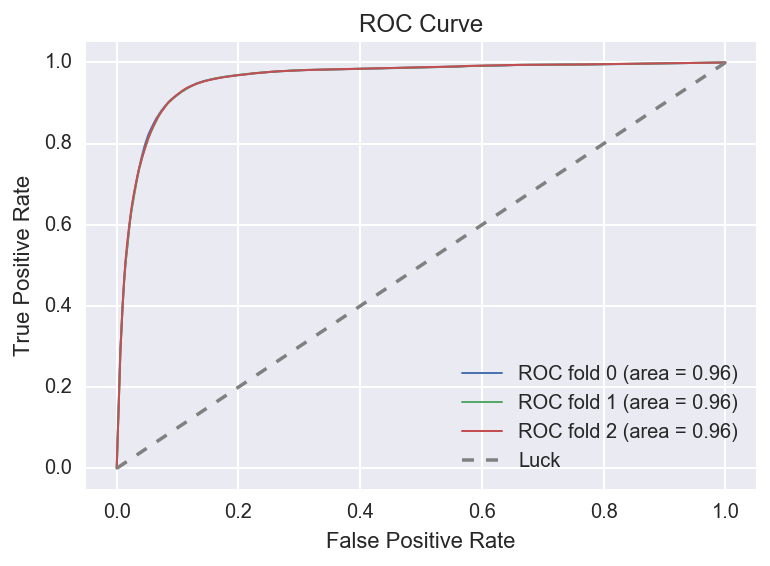

In [45]:
# ROC Curve
cv = StratifiedKFold(y, n_folds=3)

fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv):
    prob = clf.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

ax.plot([0, 1], [0, 1], '--', color='grey', label='Luck')


ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Which feature are the most predictive for the conversion ?

The most interesting part for us at this point is to see which features of the model are the most predictive.

In [50]:
feature_importance_df = pd.DataFrame(zip(X.design_info.column_names, 100 * clf.feature_importances_), columns=['feature', 'importance'])

In [51]:
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

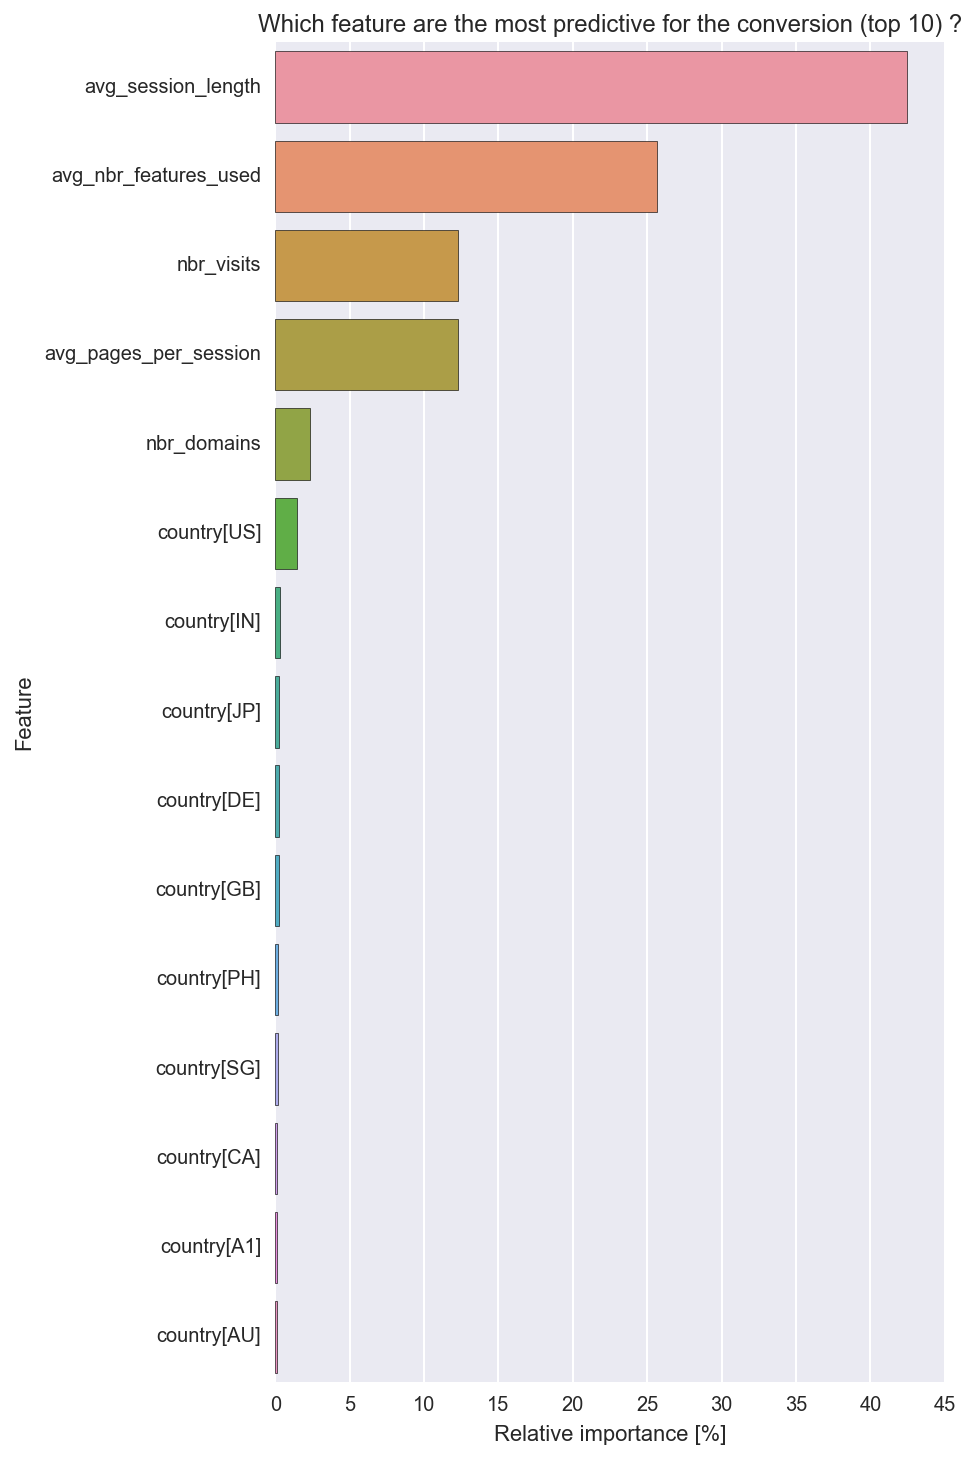

In [53]:
top_features = feature_importance_df.head(15)

fig,ax = plt.subplots(figsize=(6,12))
sns.barplot(top_features.importance, top_features.feature, ax=ax)
ax.set_xlabel('Relative importance [%]')
ax.set_ylabel('Feature')
ax.set_title('Which feature are the most predictive for the conversion (top 10) ?')
plt.show()

### How does the user metrics compare between the two training class ?

In [60]:
converted_metrics = dataset_df[dataset_df.converted==True][['avg_nbr_features_used',
                                                            'avg_session_length',
                                                            'avg_pages_per_session',
                                                            'nbr_visits',
                                                            'nbr_domains']].mean()

In [61]:
unconverted_metrics = dataset_df[dataset_df.converted==False][['avg_nbr_features_used',
                                                                'avg_session_length',
                                                                'avg_pages_per_session',
                                                                'nbr_visits',
                                                                'nbr_domains']].mean()

In [62]:
users_metrics = pd.concat([converted_metrics, unconverted_metrics], axis=1).rename(columns={0:'converted', 1:'unconverted'})

In [63]:
users_metrics

,converted,unconverted
avg_nbr_features_used,1.736096,1.554349
avg_session_length,1813.955791,115.573260
avg_pages_per_session,31.507924,2.769053
nbr_visits,46.241825,5.814282
nbr_domains,1.178238,1.045337


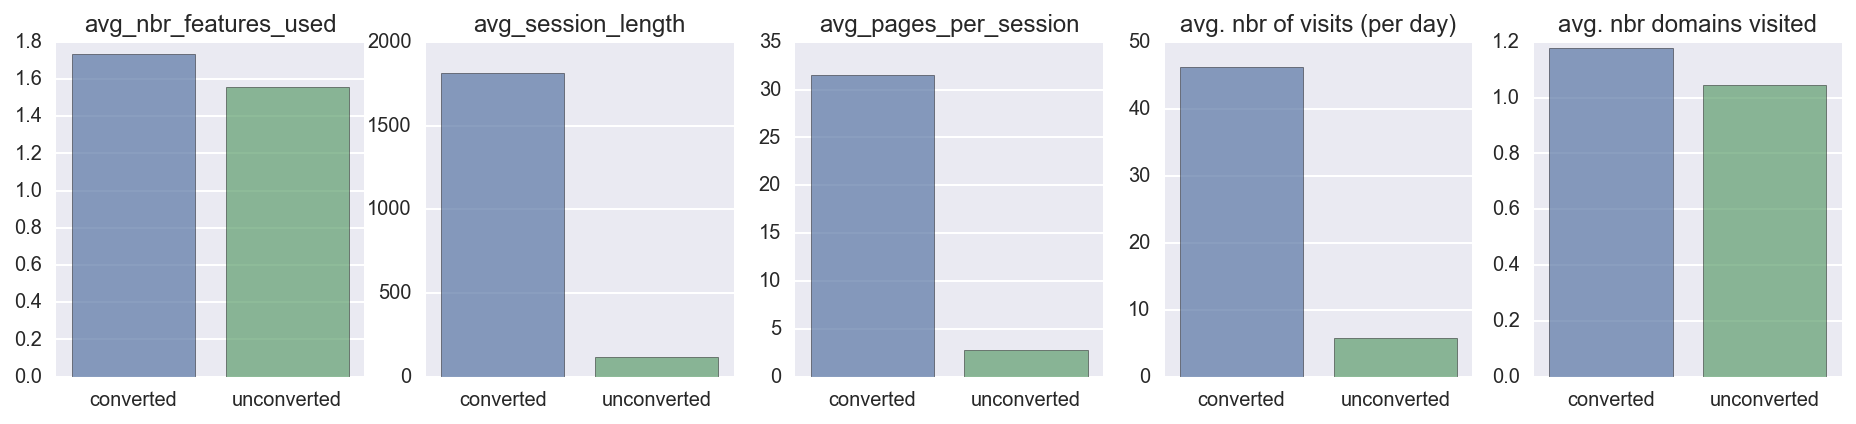

In [66]:
fig, axes = plt.subplots(1,5, figsize=(16,3))
sns.barplot(users_metrics.ix['avg_nbr_features_used'].index,
            users_metrics.ix['avg_nbr_features_used'].values, ax=axes[0], alpha=0.7)
axes[0].set_title('avg_nbr_features_used')

sns.barplot(users_metrics.ix['avg_session_length'].index,
            users_metrics.ix['avg_session_length'].values, ax=axes[1], alpha=0.7)
axes[1].set_title('avg_session_length')


sns.barplot(users_metrics.ix['avg_pages_per_session'].index,
            users_metrics.ix['avg_pages_per_session'].values, ax=axes[2], alpha=0.7)
axes[2].set_title('avg_pages_per_session')


sns.barplot(users_metrics.ix['nbr_visits'].index,
            users_metrics.ix['nbr_visits'].values, ax=axes[3], alpha=0.7)
axes[3].set_title('avg. nbr of visits (per day)')


sns.barplot(users_metrics.ix['nbr_domains'].index,
            users_metrics.ix['nbr_domains'].values, ax=axes[4], alpha=0.7)
axes[4].set_title('avg. nbr domains visited')


plt.show()

### Suggestion of segmentation

Finally, now that we know precisely which feature are the most important, we can suggest interesting segmentation:

In [153]:
# Suggestion of segmentation #1
segment1 = dataset_df[(dataset_df.avg_session_length < 500)]
segment2 = dataset_df[dataset_df.avg_session_length > 500]

In [154]:
segment1_conversion_rate= 100 * segment1[segment1.converted].user_id.count().astype(float) / segment1.user_id.count()
print segment1_conversion_rate

20.2122723931


In [155]:
segment2_conversion_rate = 100 * segment2[segment2.converted].user_id.count().astype(float) / segment2.user_id.count()
print segment2_conversion_rate

90.0282307798


In [156]:
# Output to the user
print "Given your current goal, segmenting on avg_session_length might be a good idea"
pct_increase = 100 * (segment2_conversion_rate-segment1_conversion_rate) / segment1_conversion_rate
print "Visitor with a avg_session_length > 500 are {0:.1f}% more likely to convert".format(pct_increase)

Given your current goal, segmenting on avg_session_length might be a good idea
Visitor with a avg_session_length > 500 are 345.4% more likely to convert


In [157]:
# Suggestion of segmentation #2
segment1 = dataset_df[(dataset_df.nbr_visits < 30)]
segment2 = dataset_df[dataset_df.nbr_visits > 30]

In [158]:
segment1_conversion_rate= 100 * segment1[segment1.converted].user_id.count().astype(float) / segment1.user_id.count()
print segment1_conversion_rate

41.7983188268


In [159]:
segment2_conversion_rate = 100 * segment2[segment2.converted].user_id.count().astype(float) / segment2.user_id.count()
print segment2_conversion_rate

78.7083823631


In [160]:
# Output to the user
print "Given your current goal, segmenting on nbr_visits might be a good idea"
pct_increase = 100 * (segment2_conversion_rate-segment1_conversion_rate) / segment1_conversion_rate
print "Visitor with a nbr_visits > 30 are {0:.1f}% more likely to convert".format(pct_increase)

Given your current goal, segmenting on nbr_visits might be a good idea
Visitor with a nbr_visits > 30 are 88.3% more likely to convert


etc ..